In [3]:
%pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import missingno as msno
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [5]:
train_transaction = pd.read_csv('./data/raw/train_transaction.csv')
train_identity = pd.read_csv('./data/raw/train_identity.csv')
test_transaction = pd.read_csv('./data/raw/test_transaction.csv')
test_identity = pd.read_csv('./data/raw/test_identity.csv')

In [6]:
train_transaction = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test_transaction = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

In [5]:
display(train_transaction.head())

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


### Distribution of fraud and non fraud labels in dataset

<function matplotlib.pyplot.show(close=None, block=None)>

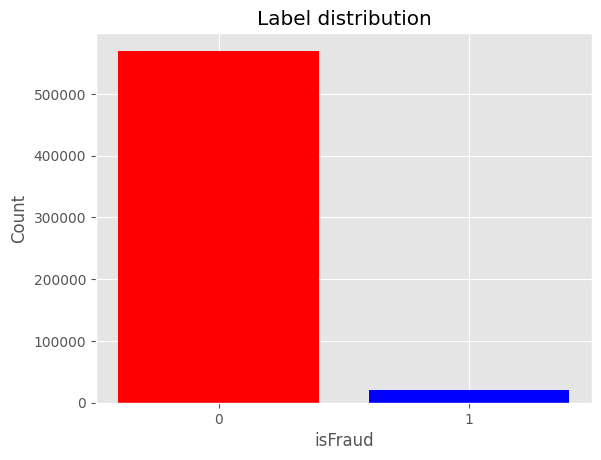

In [8]:
X_train = train_transaction.drop("isFraud", axis=1)
train_transaction["isFraud"] = train_transaction["isFraud"].astype("category")
y_train = train_transaction["isFraud"]

isfraud, count = np.unique(y_train, return_counts=True)
plt.bar(isfraud, count, color=["red", "blue"], tick_label=isfraud)
plt.title("Label distribution")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show

In [9]:
# Imbalanced dataset
is_fraud = train_transaction[train_transaction["isFraud"] == 1]
not_fraud = train_transaction[train_transaction["isFraud"] == 0]

# Random under-sampling
length_isfraud = len(is_fraud)
notfraud_undersample = not_fraud.sample(length_isfraud)

train_transaction_undersampled = pd.concat([is_fraud, notfraud_undersample], axis=0)
X_train_undersampled = train_transaction_undersampled.drop("isFraud", axis=1)
y_train_undersampled = train_transaction_undersampled["isFraud"]

This graph suggests that a significant number of transactions are non fradulent, and only a small % of them are fradulent (as one would expect). It should be noted that this dataset is extremely uneven, and to keep this into consideration when we develop our models. We can either perform under or over sampling techniques, or use other metrics such as a precision, recall, and AUC instead of simply accuracy.

### PCA on numerical features
- Transaction amount
- Transaction DT
- dist1, dist2
- C1 to C14
- D1 to D15

In [14]:
c_cols = [f"C{d}" for d in range(1, 15)]
d_cols = [f"D{d}" for d in range(1, 16)]

numerical_feat = ["TransactionAmt", "TransactionDT", "dist1", "dist2"]
numerical_feat.extend(c_cols)
numerical_feat.extend(d_cols)

numerical_feat_df = train_transaction[numerical_feat]
numerical_feat_df.fillna(0, inplace=True)

display(numerical_feat_df.head())

C:\Users\ericb\AppData\Local\Temp\ipykernel_12760\1211399647.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_feat_df.fillna(0, inplace=True)


,TransactionAmt,TransactionDT,dist1,dist2,C1,C2,C3,C4,C5,C6,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,68.5,86400,19.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,13.0,13.0,0.0,0.0,0.0,0.0
1,29.0,86401,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59.0,86469,287.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,315.0,0.0,0.0,0.0,315.0
3,50.0,86499,0.0,0.0,2.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,84.0,0.0,0.0,0.0,0.0,111.0
4,50.0,86506,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(numerical_feat_df) # Standardize columns in the dataframe

n_components = 5
pca = PCA(n_components=n_components, random_state=123)
numerical_feat_pca = pca.fit_transform(scaled_df)

numerical_feat_pca_df = pd.DataFrame(numerical_feat_pca, columns=numerical_feat[:n_components])
display(numerical_feat_pca_df.head())

,TransactionAmt,TransactionDT,dist1,dist2,C1
0,-0.336541,-1.472317,-0.321054,-0.019480,-0.321738
1,-0.343630,-1.619046,-0.329389,0.007075,-0.293361
2,-0.327144,-0.263492,-0.516326,-0.417492,-0.168376
3,-0.252027,-0.443034,-0.261360,-0.236636,0.033482
4,-0.337922,-1.622137,-0.332617,0.000534,-0.302766


Explained variation ratio for each PC:


,Feature,Explained Variance Ratio
0,TransactionAmt,0.307010
1,TransactionDT,0.135729
2,dist1,0.085226
3,dist2,0.066705
4,C1,0.045887


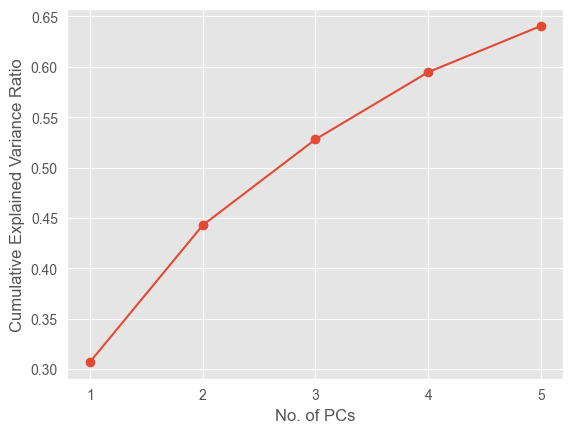

In [26]:
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

print('Explained variation ratio for each PC:')
display(pd.DataFrame(
    {"Feature": numerical_feat[:n_components], 
     "Explained Variance Ratio": pca.explained_variance_ratio_}
))

plt.plot(range(1, n_components + 1), cumulative_var_ratio, marker='o')
plt.xlabel('No. of PCs')
plt.xticks(range(1, n_components + 1))
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

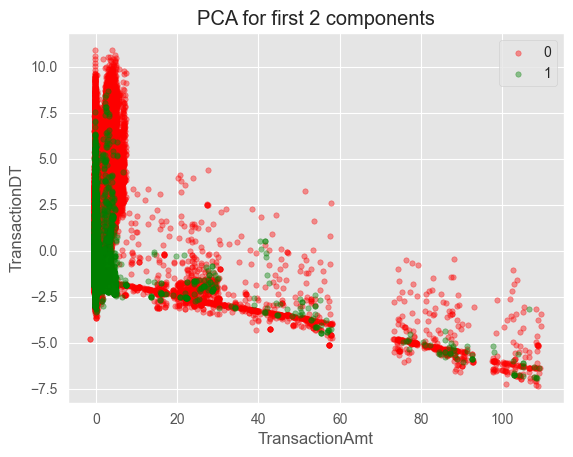

In [18]:
plt.figure()
plt.xlabel(numerical_feat[0])
plt.ylabel(numerical_feat[1])
plt.title("PCA for first 2 components")
labels = [0, 1]
colors = ['red', 'green']

for label, color in zip(labels,colors):
    indicesToKeep = train_transaction['isFraud'] == label
    
    plt.scatter(numerical_feat_pca_df.loc[indicesToKeep, numerical_feat[0]],
                numerical_feat_pca_df.loc[indicesToKeep, numerical_feat[1]], c=color, s=15, alpha=0.4)

plt.legend(labels)

From explained variance ratios, transaction amount provides the most information when projecting from 33 dimensions to a lower dimension count, followed by transaction DT. The remaining principal components are not very significant as they explain less than 10% of the variance when reducing dimensions. 

---

In [12]:
print(train_transaction["TransactionDT"].head(10))
print(train_transaction["M2"].head(10))

0    86400
1    86401
2    86469
3    86499
4    86506
5    86510
6    86522
7    86529
8    86535
9    86536
Name: TransactionDT, dtype: int64
0      T
1    NaN
2      T
3    NaN
4    NaN
5      T
6      T
7    NaN
8    NaN
9      T
Name: M2, dtype: object


In [13]:
display(train_identity.head())

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [14]:
print(train_transaction.columns)

Index(['TransactionID_x', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=435)


In [15]:
train_transaction['D1n'] =  train_transaction['D1'] -   train_transaction.TransactionDT/np.float32(24*60*60)

## Missing Values in Columns

In [16]:
#Can remove columns with 90% missing values

def top_missing_cols(df,n=10,thresh=90):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [17]:
top_missing_cols(train_transaction, n = 12, thresh=90)

There are 416 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%


,col,missing_percent
0,id_24,99.196159
1,id_25,99.130965
2,id_07,99.127070
3,id_08,99.127070
4,id_21,99.126393
5,id_26,99.125715
6,id_27,99.124699
7,id_23,99.124699
8,id_22,99.124699
9,dist2,93.628374


## TransactionDT distribution

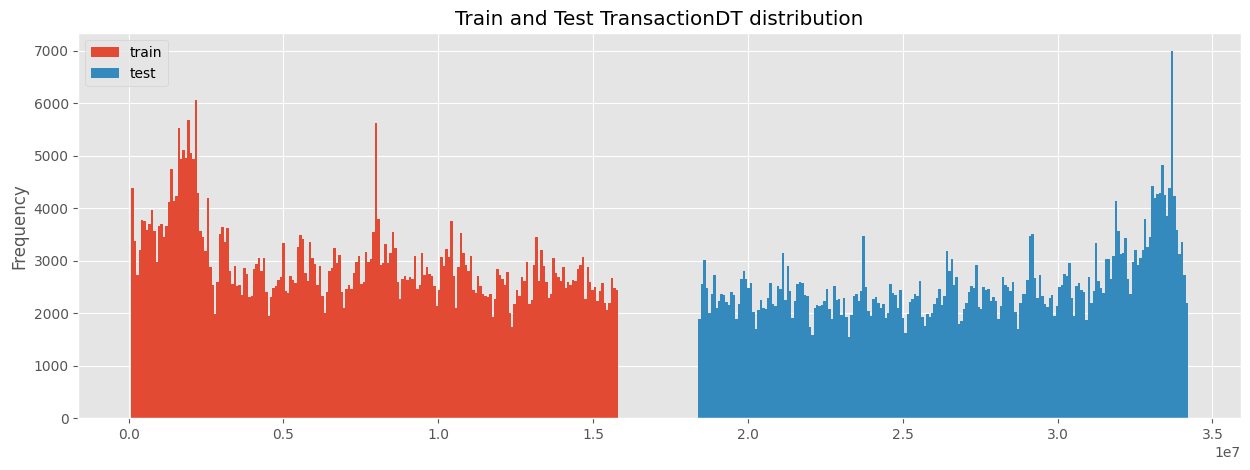

In [18]:
train_transaction['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='train', bins=200, title='Train and Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist', label='test', bins=200)
plt.legend()
plt.show()

As TransactionDT is defined as the time delta of the transaction, we can deduce that the training and test datasets are split by time. This may potentially impact any cross validation techniques.

<Axes: title={'center': 'Test Log Transaction Amt'}, ylabel='Frequency'>

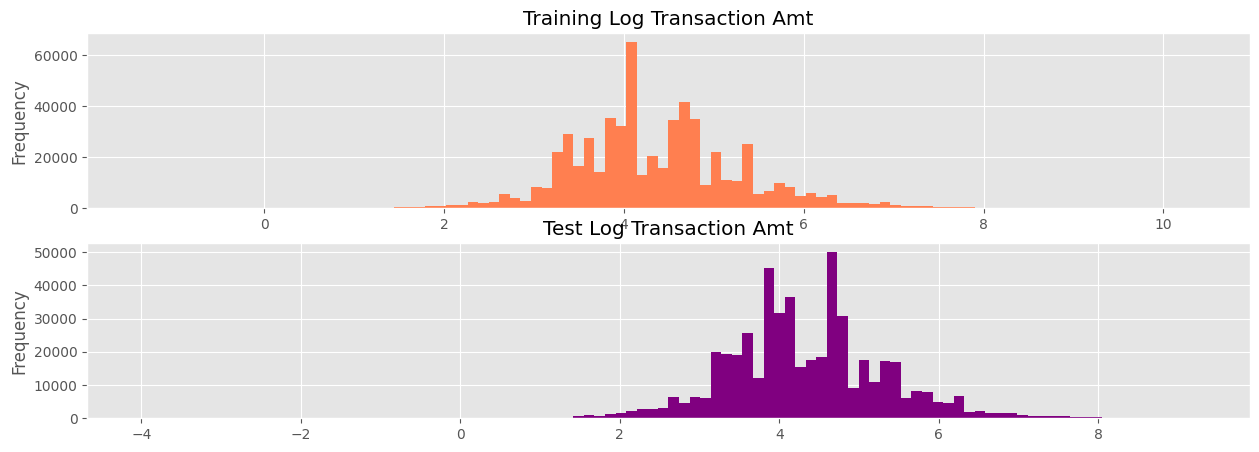

In [19]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(15, 6))
train_transaction['TransactionAmt']\
    .apply(np.log)\
        .plot(kind='hist', 
              figsize=(15, 5), 
              label='train', 
              bins=100, 
              title='Training Log Transaction Amt',
              color='coral',
              ax=ax1)

test_transaction['TransactionAmt']\
    .apply(np.log)\
        .plot(kind='hist', 
              figsize=(15, 5), 
              label='train', 
              bins=100, 
              title='Test Log Transaction Amt',
              color='purple',
              ax=ax2)

## Distribution of TransactionAmt grouped by isFraud

<Axes: title={'center': 'Log Transaction Amt - No Fraud'}, ylabel='Frequency'>

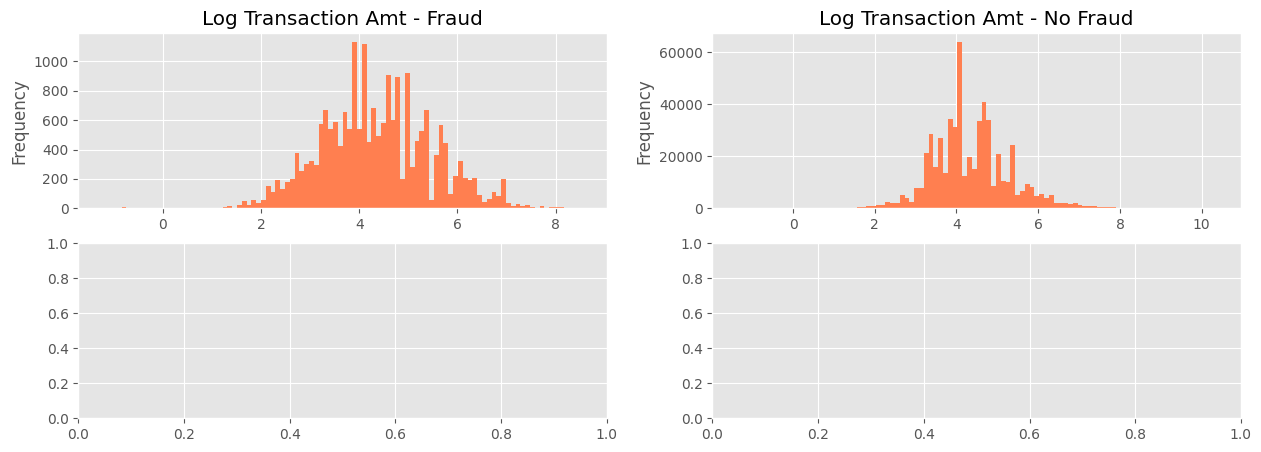

In [20]:
# now we split by fraud and no fraud
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt']\
    .apply(np.log)\
        .plot(kind='hist', 
              figsize=(15, 5), 
              label='Fraud', 
              bins=100, 
              title='Log Transaction Amt - Fraud',
              color='coral',
              ax=ax1)

train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt']\
    .apply(np.log)\
        .plot(kind='hist', 
              figsize=(15, 5), 
              label='No Fraud', 
              bins=100, 
              title='Log Transaction Amt - No Fraud',
              color='coral',
              ax=ax2)

# test_transaction[test_transaction['isFraud'] == 1]['TransactionAmt']\
#     .apply(np.log)\
#         .plot(kind='hist', 
#               figsize=(15, 5), 
#               label='Fraud', 
#               bins=100, 
#               title='Log Transaction Amt - Fraud',
#               color='purple',
#               ax=ax3)

# test_transaction[test_transaction['isFraud'] == 0]['TransactionAmt']\
#     .apply(np.log)\
#         .plot(kind='hist', 
#               figsize=(15, 5), 
#               label='No Fraud', 
#               bins=100, 
#               title='Log Transaction Amt - No Fraud',
#               color='purple',
#               ax=ax4)

<Axes: title={'center': 'Test TransactionAmt distribution'}, ylabel='Frequency'>

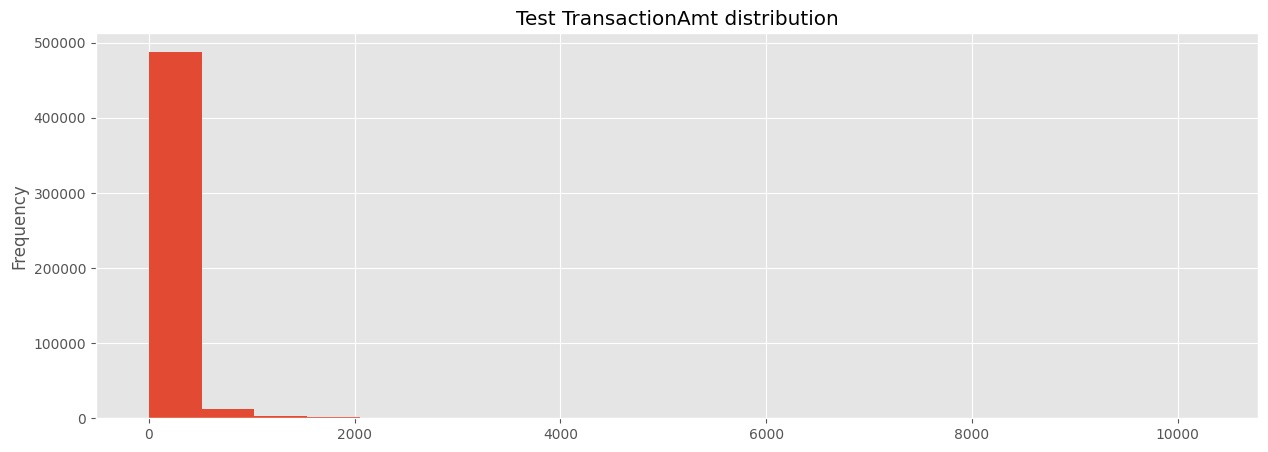

In [21]:
test_transaction['TransactionAmt'].plot(kind='hist', figsize=(15, 5), label='test', bins=20, title='Test TransactionAmt distribution')

In [22]:
Ds = ["D" + str(x) for x in range(1,16)]
Ds.append("TransactionDT")
# print(Ds)
train_transaction[Ds]

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,TransactionDT
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,86400
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,86401
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,86469
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,86499
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,56.0,56.0,NaN,NaN,NaN,56.0,15811047
590536,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,15811049
590537,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,15811079
590538,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,22.0,NaN,NaN,NaN,22.0,15811088


In [23]:
train_transaction['D1'] - train_transaction.TransactionDT/np.float32(24*60*60)

0          13.000000
1          -1.000012
2          -1.000799
3         110.998854
4          -1.001227
             ...    
590535   -153.998229
590536   -182.998252
590537   -182.998600
590538   -160.998704
590539   -182.999201
Length: 590540, dtype: float64

In [ ]:
'''
Hypothesis: To identify users, possible features to use: 
"card1": "card6", 
"addr1", "addr2",
P_emaildomain
R_emaildomain
'''
train_transaction.loc[:, "M1":"M9"]

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
590535,T,T,T,M0,T,F,F,F,T
590536,T,F,F,M0,F,T,F,F,F
590537,T,F,F,NaN,NaN,T,NaN,NaN,NaN
590538,T,T,T,M0,F,T,NaN,NaN,NaN


In [ ]:
card_cols = [c for c in train_transaction.columns if 'card' in c]
train_transaction[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


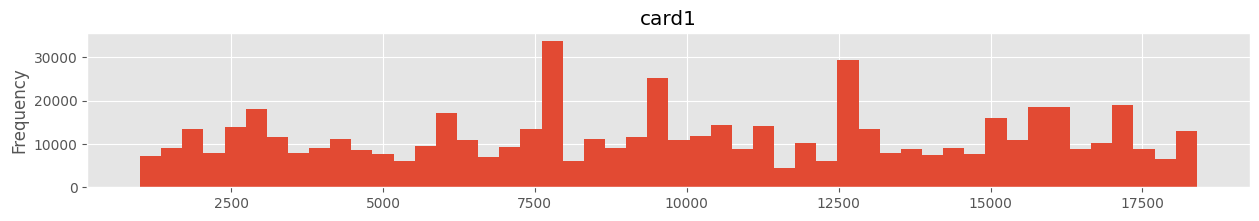

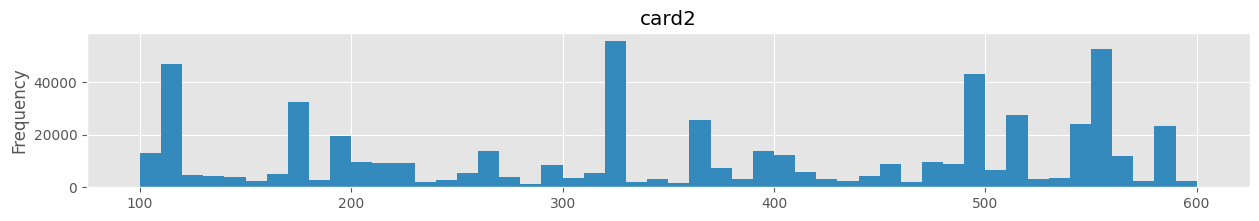

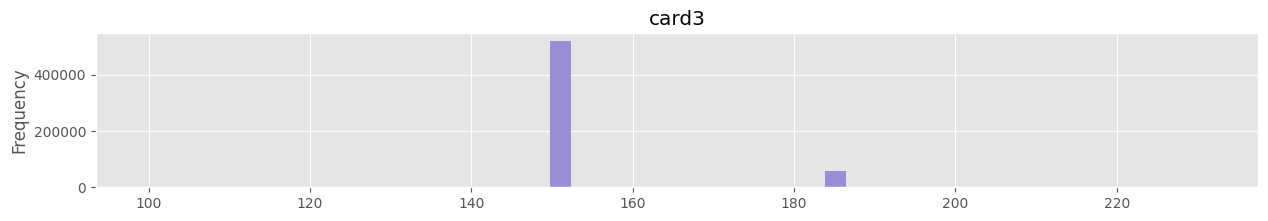

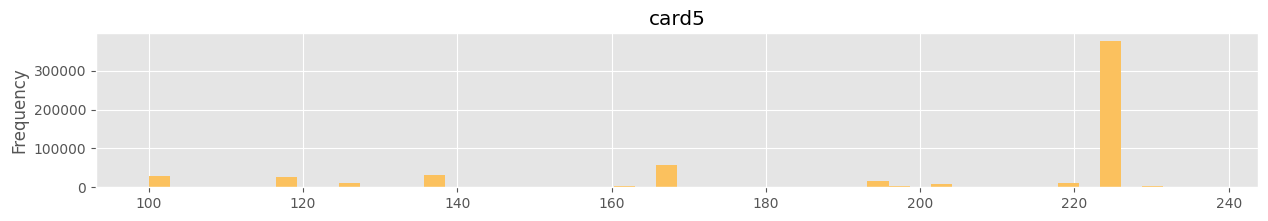

In [ ]:
color_idx = 0
for c in card_cols:
    if train_transaction[c].dtype in ['float64','int64']:
        train_transaction[c].plot(kind='hist',
                                      title=c,
                                      bins=50,
                                      figsize=(15, 2),
                                      color=color_pal[color_idx])
    color_idx += 1
    plt.show()

In [ ]:
train_transaction['TransactionAmt'] = train_transaction['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(train_transaction['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))


Transaction Amounts Quantiles:
0.010       9.2440
0.025      14.5010
0.100      25.9500
0.250      43.3210
0.500      68.7690
0.750     125.0000
0.900     275.2930
0.975     648.3345
0.990    1104.0000
Name: TransactionAmt, dtype: float64


In [ ]:
print('Number of row in transaction:', len(train_transaction))
print('Number of row in identity:', len(train_identity))

Number of row in transaction: 590540
Number of row in identity: 144233


<Axes: >

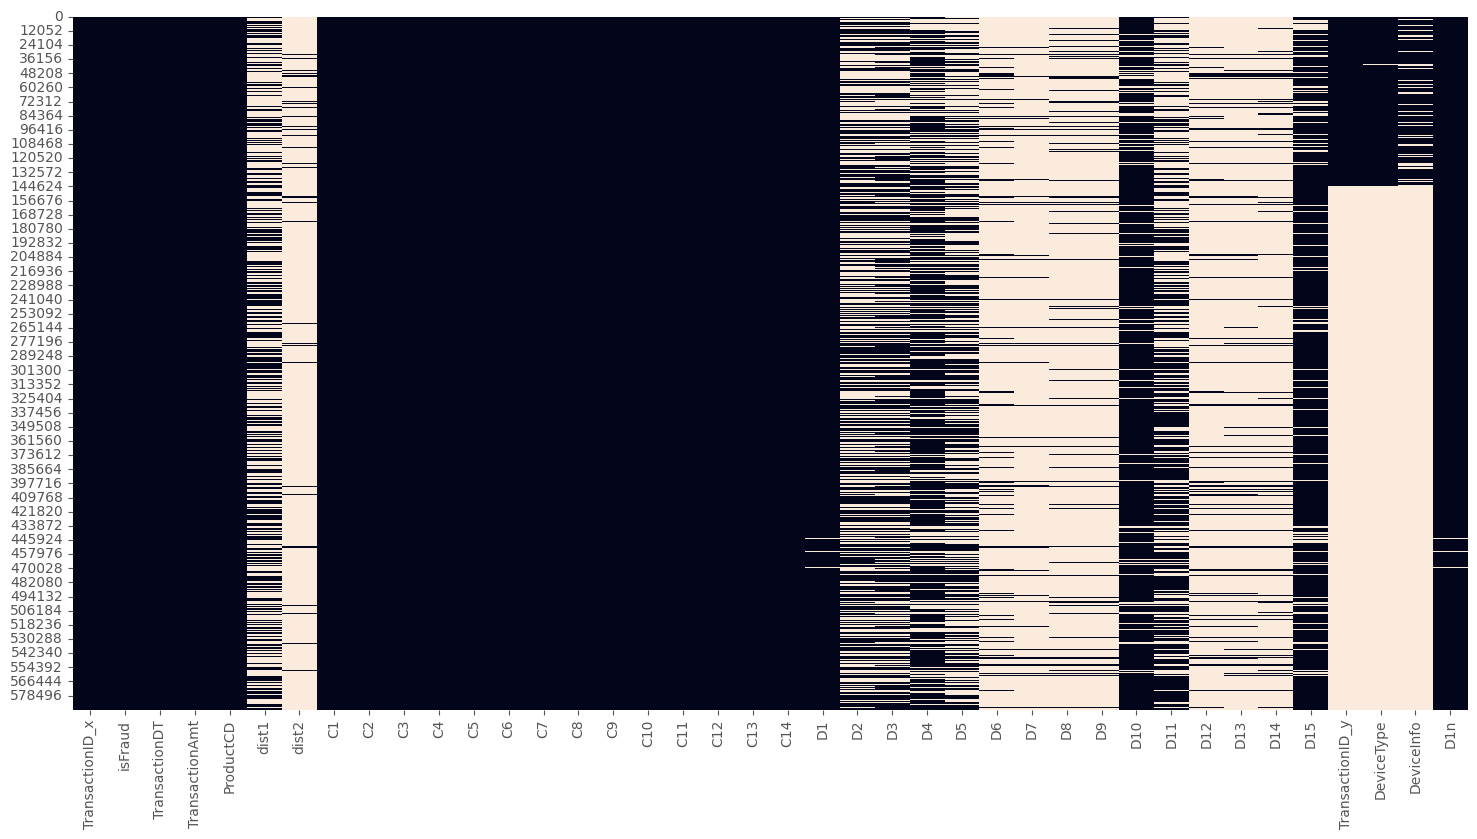

In [ ]:
train_transaction_num = train_transaction.filter(regex='isFraud|TransactionDT|TransactionAmt|dist|C|D')
plt.figure(figsize=(18,9))
sns.heatmap(train_transaction_num.isnull(), cbar= False)

<Axes: >

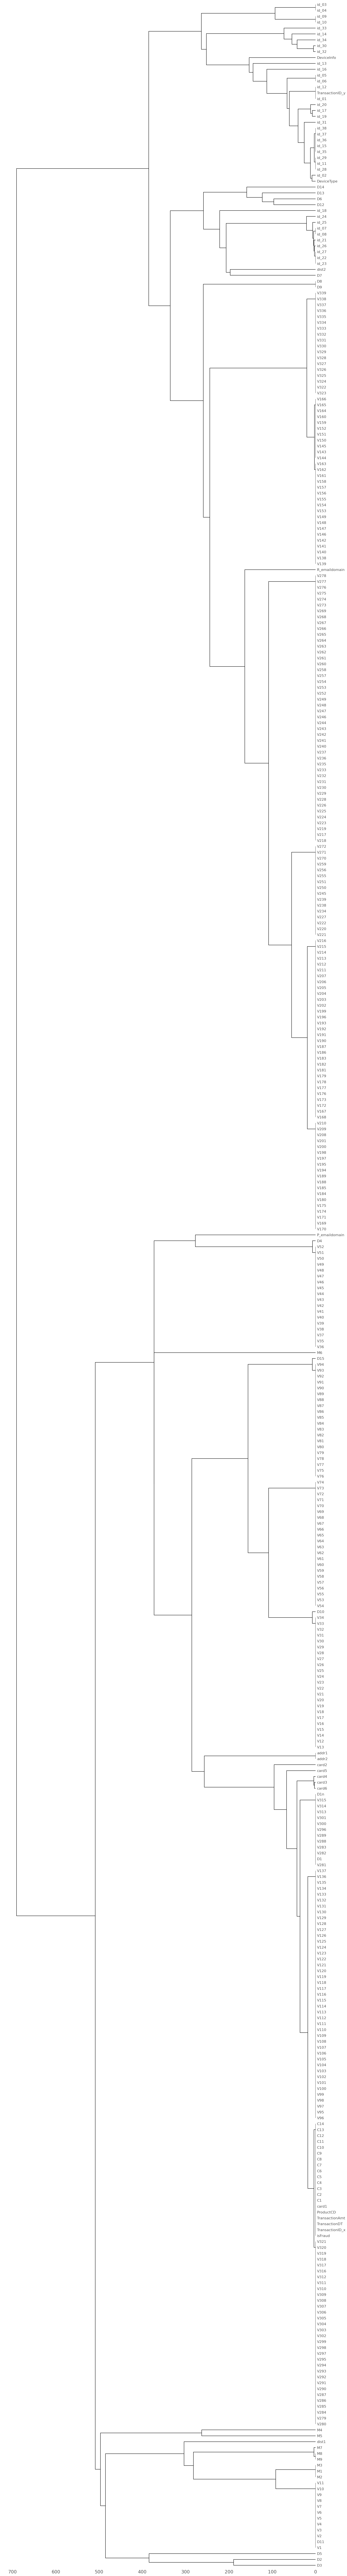

In [ ]:
msno.dendrogram(train_transaction)

# 2. Categorical Features EDA

In [8]:
train_transaction_categorical = train_transaction.filter(regex='id|card|ProductCD|addr|email|M|DeviceType|DeviceInfo|isFraud')

In [9]:
train_transaction_categorical.head()

,isFraud,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [13]:
def fraud_by_category(category, category_name):
    plt.figure(figsize=(20,8))

    total = len(train_transaction_categorical)

    plt.subplot(1,3,1)
    g = sns.countplot(x = category, data = train_transaction_categorical, hue = category)
    g.set_title(category_name + ' Distribution', fontsize = 15)
    g.set_xlabel(category_name, fontsize=15)
    g.set_ylabel("Count", fontsize=15)
    for p in g.patches:
        if p.get_x() == 0:
            continue
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 5000,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 

    plt.subplot(1,3,2)
    g1 = sns.countplot(x=category, hue='isFraud', data=train_transaction_categorical)
    g1.set_title(category_name + ' by Fraud', fontsize = 15)
    g1.set_xlabel(category_name, fontsize=15)
    g1.set_ylabel("Count", fontsize=15)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

    # visualization of table
    plt.subplot(1,3,3)
    b = train_transaction_categorical.groupby(category)['isFraud'].value_counts(normalize = True).unstack()
    b.reset_index()
    b["Total"] = 1
    bar1 = sns.barplot(x=category,  y="Total", data=b, color='red')
    bar2 = sns.barplot(x=category, y=0, data=b, color='green')
    top_bar = mpatches.Patch(color='red', label='Yes')
    bottom_bar = mpatches.Patch(color='green', label='No')
    bar1.set_title("Rate of Fraud by " + category_name)
    plt.legend(title="Fraud", handles=[top_bar, bottom_bar], loc="lower left")

## 2a. By Product Code

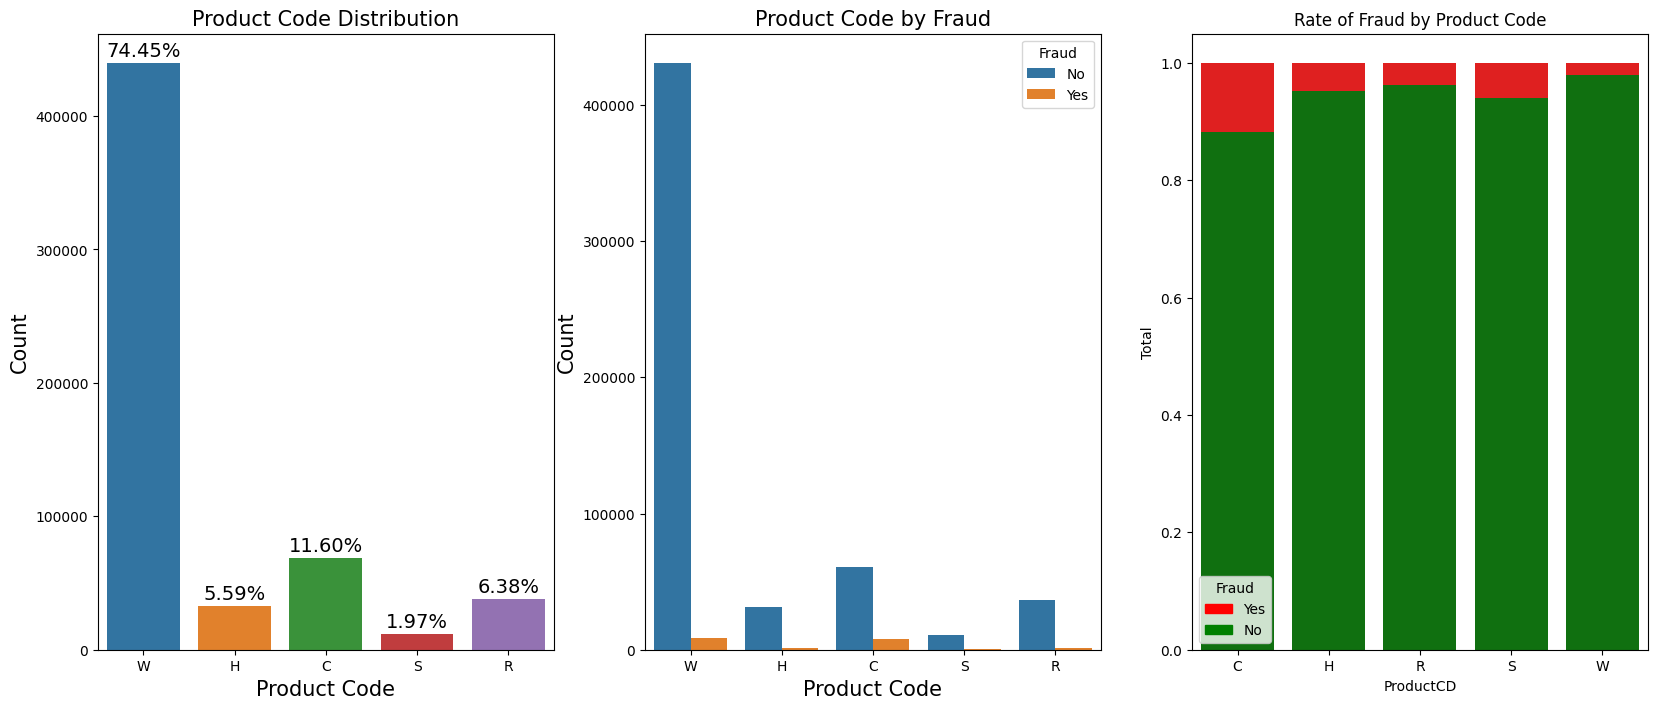

In [14]:
fraud_by_category("ProductCD", "Product Code")

We can see that product code C has the highest fraud rate. In particular, it has a fraud rate of 11%, double that of the next category of H with 5%.

In [15]:
train_transaction_categorical.groupby("ProductCD")['isFraud'].value_counts(normalize = True)

ProductCD  isFraud
C          0          0.883127
           1          0.116873
H          0          0.952338
           1          0.047662
R          0          0.962174
           1          0.037826
S          0          0.941004
           1          0.058996
W          0          0.979601
           1          0.020399
Name: proportion, dtype: float64

We can try to further investigate what kind of products is represented by Product C by looking at the TransactionAmt

<Axes: xlabel='ProductCD', ylabel='TransactionAmt'>

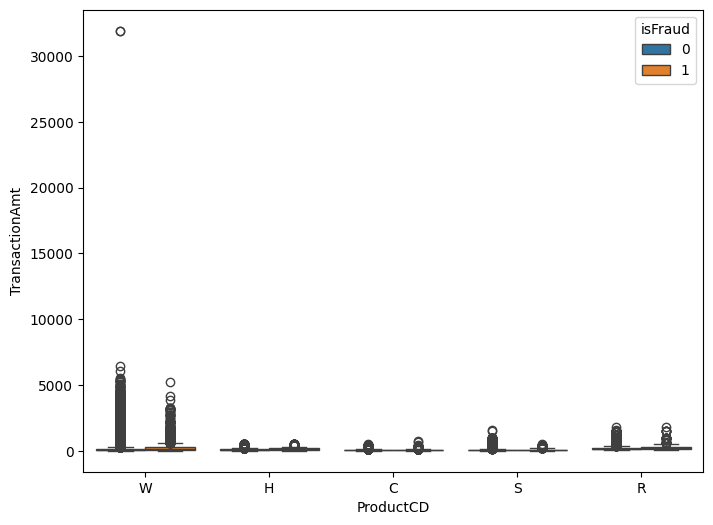

In [16]:
plt.figure(figsize=(8,6))
sns.boxplot(x="ProductCD", y="TransactionAmt", hue="isFraud", data=train_transaction)

Let's remove product code W which seem to represent higher value items.

<Axes: xlabel='ProductCD', ylabel='TransactionAmt'>

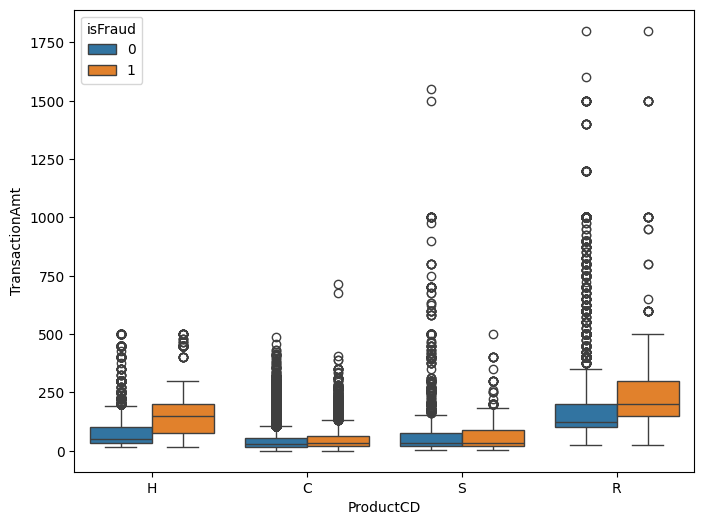

In [17]:
plt.figure(figsize=(8,6))
sns.boxplot(x="ProductCD", y="TransactionAmt", hue="isFraud", 
            data=train_transaction[train_transaction["ProductCD"] != "W"])

This seem to suggest Product Code C are items with lower value, which is in line with the hypothesis that fraudsters usually target low value items as these transactions don't get flagged as often.

## 2b. By Card Network

In [18]:
train_transaction[["card1", "card2", "card3", "card5"]].describe()

,card1,card2,card3,card5
count,590540.000000,581607.000000,588975.000000,586281.000000
mean,9898.734658,362.555488,153.194925,199.278897
std,4901.170153,157.793246,11.336444,41.244453
min,1000.000000,100.000000,100.000000,100.000000
25%,6019.000000,214.000000,150.000000,166.000000
50%,9678.000000,361.000000,150.000000,226.000000
75%,14184.000000,512.000000,150.000000,226.000000
max,18396.000000,600.000000,231.000000,237.000000


In [19]:
train_transaction[["card1", "card2", "card3", "card5"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   card1   590540 non-null  int64  
 1   card2   581607 non-null  float64
 2   card3   588975 non-null  float64
 3   card5   586281 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 18.0 MB


Card 1 has no empty rows, indicating that it could be ID of the card, and hence is recorded in every transaction. <br>
We shall not do any further analysis as their values are already encoded, and we are unable to get any meaningful insights based on their values

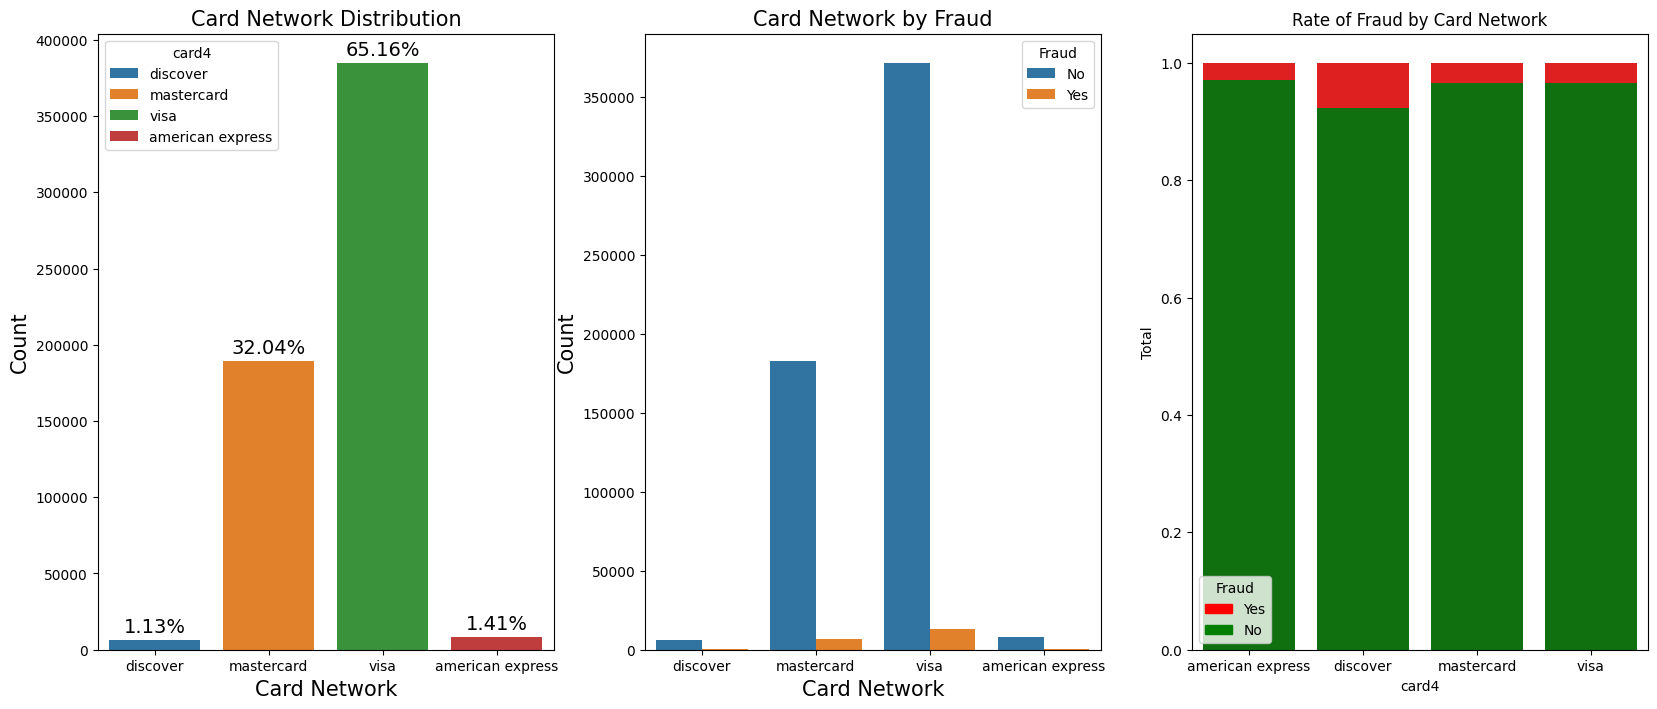

In [20]:
fraud_by_category("card4", "Card Network")

Only American Express cards have lower fraud rate, while the other 3 networks are roughly similar.

## 2c. By Card Type

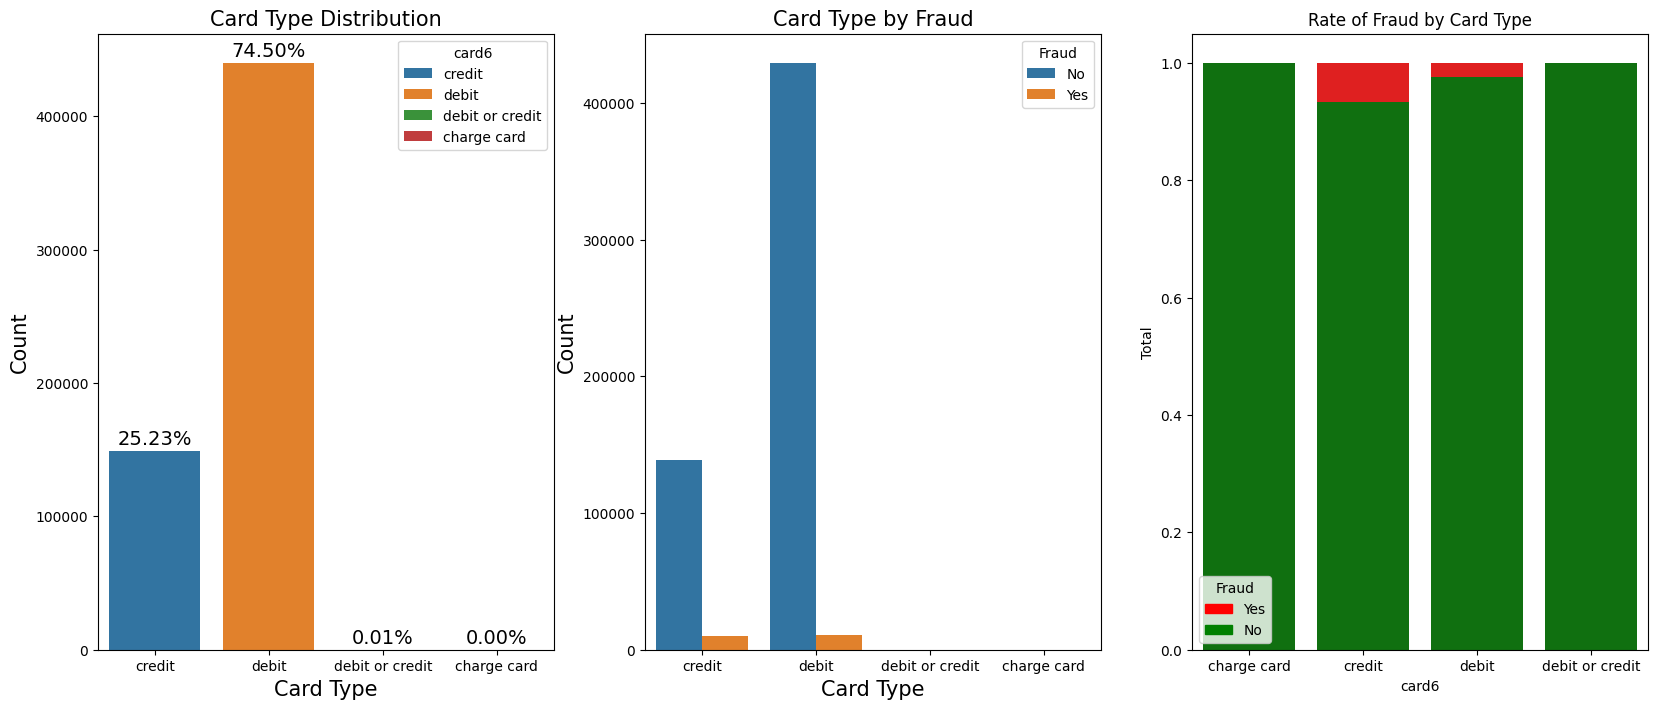

In [21]:
fraud_by_category("card6", "Card Type")

Credit cards seem to have a higher fraud rate compared to debit cards. On the other hand, usage of charge card is extremely low.

## 2d. By Purchaser and Recipient Email

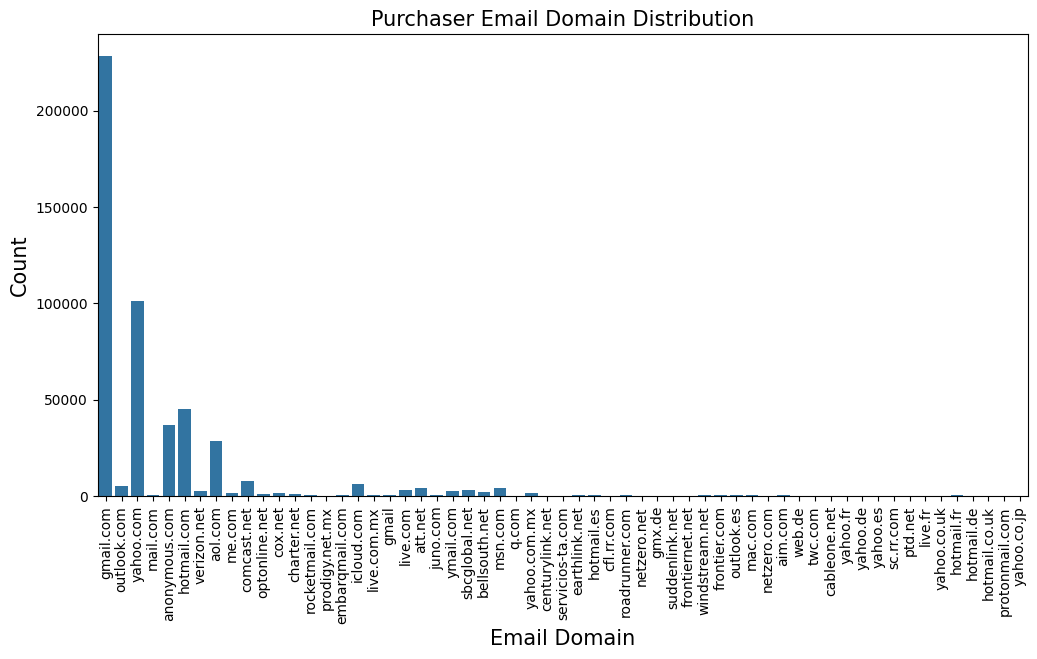

In [22]:
plt.figure(figsize=(12,6))

g = sns.countplot(x = 'P_emaildomain', data = train_transaction)
g.set_title('Purchaser Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Since there are too many emails domains, we shall aggregate email domains according to their parent domain.

In [23]:
emails = train_transaction[["isFraud", "P_emaildomain", "R_emaildomain"]]
emails["P_parent_emaildomain"] = emails["P_emaildomain"].str.split(".", expand=True)[0]
emails["R_parent_emaildomain"] = emails["R_emaildomain"].str.split(".", expand=True)[0]

/var/folders/8b/n4frqn8n3f927hpnmlxv1dlr0000gp/T/ipykernel_46736/1300069136.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emails["P_parent_emaildomain"] = emails["P_emaildomain"].str.split(".", expand=True)[0]
/var/folders/8b/n4frqn8n3f927hpnmlxv1dlr0000gp/T/ipykernel_46736/1300069136.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emails["R_parent_emaildomain"] = emails["R_emaildomain"].str.split(".", expand=True)[0]


In [24]:
def fraud_rate(category, category_name, title, df):
    df2 = df[[category, "isFraud"]].fillna("Nan")
    fraud_rate = df2.groupby(category, dropna=False)["isFraud"].value_counts(normalize=True).unstack().\
    fillna(0)[1].sort_values(ascending=False)
    plt.figure(figsize=(12,6))

    g = sns.countplot(x = category, data = df2, order=fraud_rate.index, hue = category)
    g.set_title(title, fontsize = 15)
    g.set_xlabel(category_name, fontsize=15)
    g.set_ylabel("Count", fontsize=15)
    plt.xticks(rotation= "vertical")

    r = g.twinx()
    r = sns.pointplot(x=fraud_rate.index, y=fraud_rate, color='blue', markersize=5)
    r.set_ylabel("Fraud Rate", color="Blue")
    plt.show()

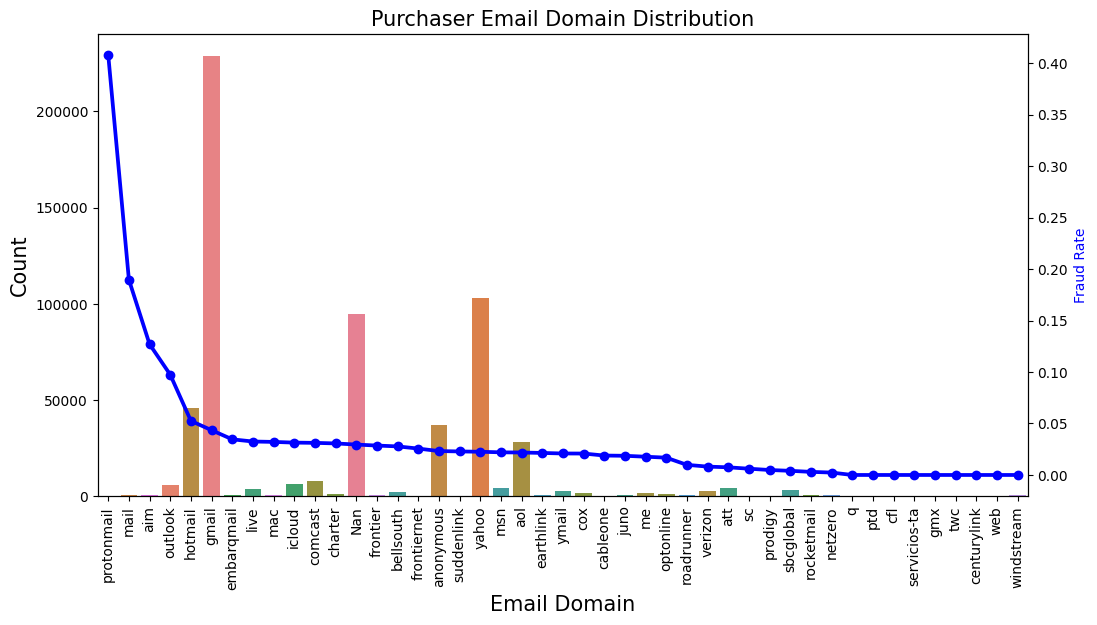

In [25]:
fraud_rate("P_parent_emaildomain", "Email Domain", "Purchaser Email Domain Distribution", emails)

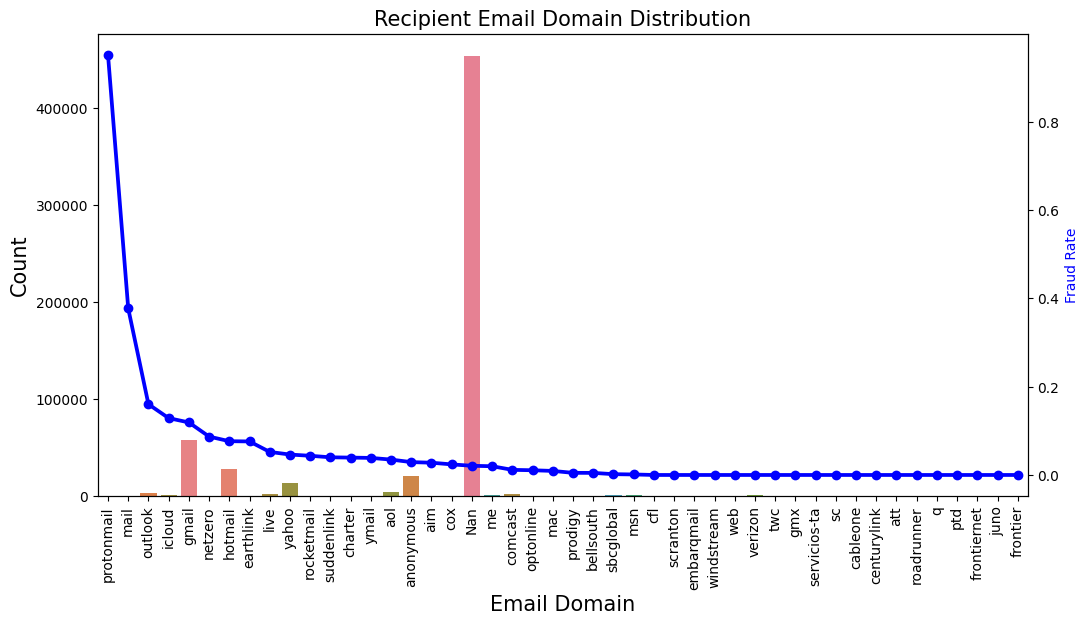

In [26]:
fraud_rate("R_parent_emaildomain", "Email Domain", "Recipient Email Domain Distribution", emails)

As can be seen from both purchaser and recipient email domains, protonmail have an extremely high fraud rate.

## 2e. Columns M1 – M9

In [27]:
train_transaction_categorical.loc[:, "M1": "M9"].describe()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
count,319440,319440,319440,309096,240058,421180,244275,244288,244288
unique,2,2,2,3,2,2,2,2,2
top,T,T,T,M0,F,F,F,F,T
freq,319415,285468,251731,196405,132491,227856,211374,155251,205656


In [28]:
train_transaction_categorical.shape

(590540, 61)

In [29]:
train_transaction_categorical.loc[:, "M1": "M9"].apply(lambda x: x.value_counts())

,M1,M2,M3,M4,M5,M6,M7,M8,M9
F,25.0,33972.0,67709.0,NaN,132491.0,227856.0,211374.0,155251.0,38632.0
M0,NaN,NaN,NaN,196405.0,NaN,NaN,NaN,NaN,NaN
M1,NaN,NaN,NaN,52826.0,NaN,NaN,NaN,NaN,NaN
M2,NaN,NaN,NaN,59865.0,NaN,NaN,NaN,NaN,NaN
T,319415.0,285468.0,251731.0,NaN,107567.0,193324.0,32901.0,89037.0,205656.0


Since only M4 has values of [M0, M1, M2] instead of [T, F], we shall investigate that column

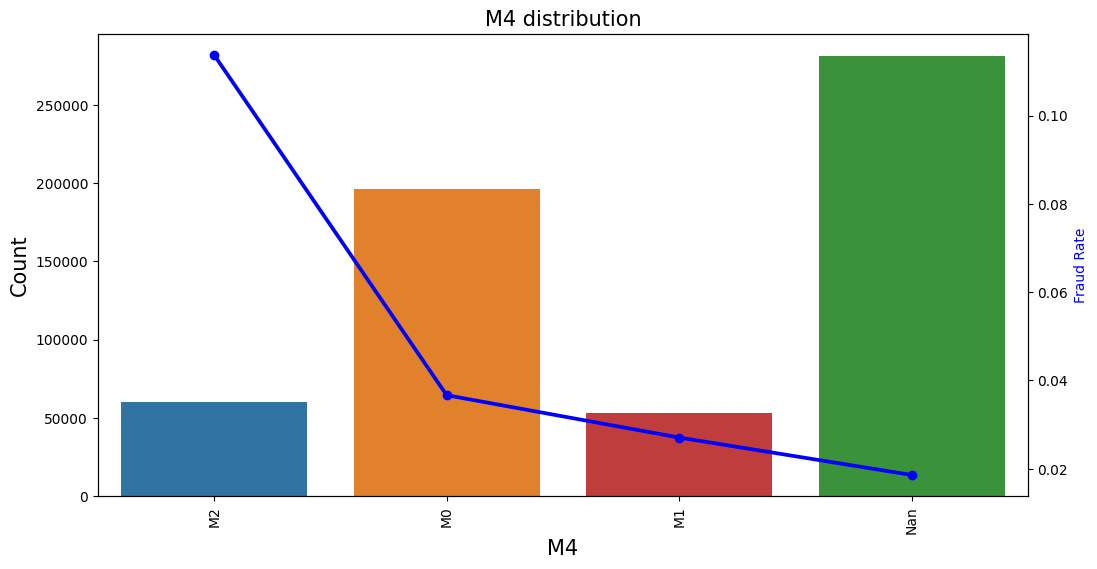

In [30]:
fraud_rate("M4", "M4", "M4 distribution", train_transaction_categorical)

M2 has the highest fraud rate, however we don't have the exact details on what this value may represent.

## 2f. By Device Type

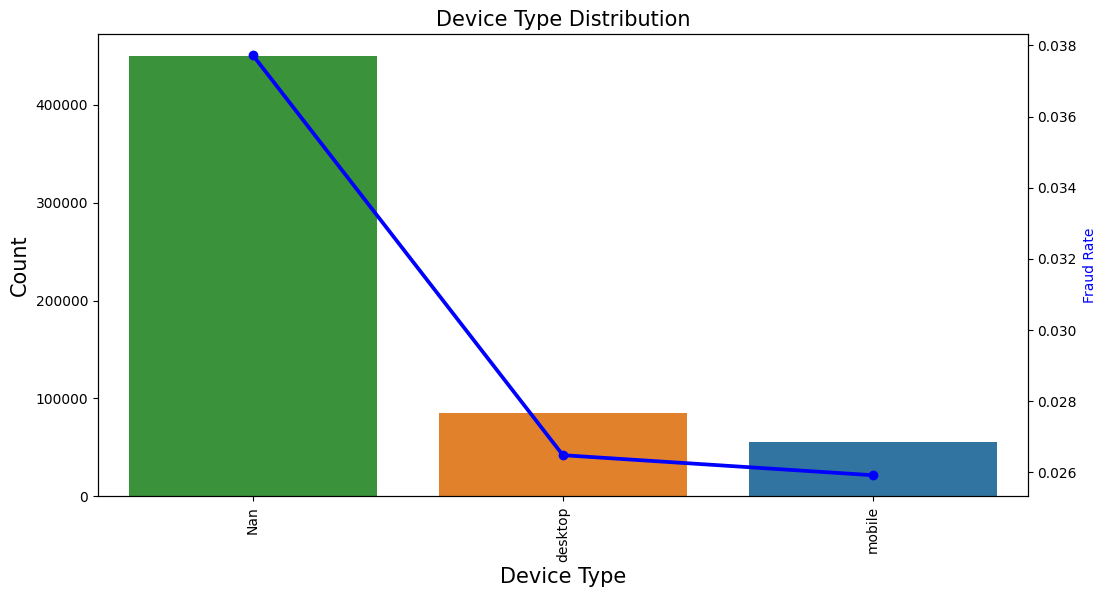

In [31]:
fraud_rate("DeviceType", "Device Type", "Device Type Distribution", train_transaction)

## 2g. By Device Info

In [32]:
train_transaction_categorical["DeviceInfo"].value_counts()

DeviceInfo
Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
               ...  
LGMS345            1
verykool           1
XT1072             1
LG-H931            1
0PJA2              1
Name: count, Length: 1786, dtype: int64

In [33]:
devicelist = train_transaction_categorical.groupby('DeviceInfo').filter(lambda x: len(x) >500)['DeviceInfo'].unique()
devicelist

array(['iOS Device', 'Windows', 'MacOS', 'SM-J700M Build/MMB29K',
       'Trident/7.0', 'rv:57.0', 'rv:11.0'], dtype=object)

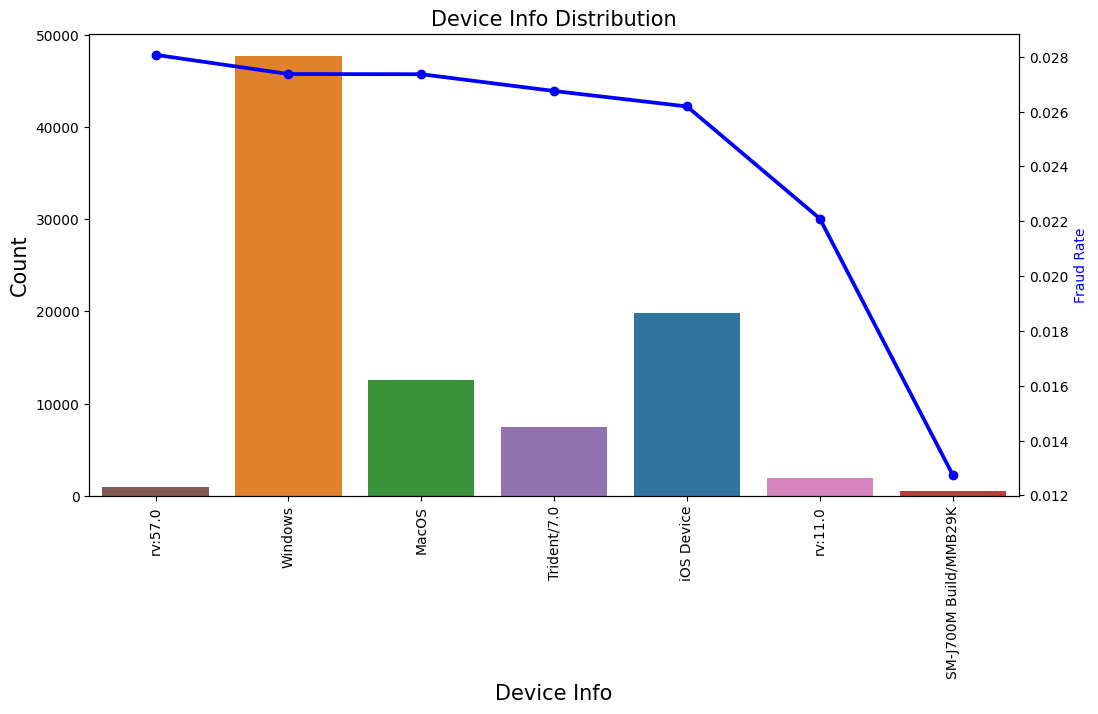

In [34]:
fraud_rate("DeviceInfo", "Device Info", "Device Info Distribution", 
           train_transaction_categorical[train_transaction_categorical["DeviceInfo"].isin(devicelist)])

We can see that fraud rate is higher the popular devices. Interestingly, Trident/7.0, rv:11.0, rv:57.0 are used by Internet Explorer on different Windows version

## 2h. Columns id_12 – id_38

In [35]:
train_transaction_categorical.loc[:, "id_12": "id_38"].dtypes

id_12     object
id_13    float64
id_14    float64
id_15     object
id_16     object
id_17    float64
id_18    float64
id_19    float64
id_20    float64
id_21    float64
id_22    float64
id_23     object
id_24    float64
id_25    float64
id_26    float64
id_27     object
id_28     object
id_29     object
id_30     object
id_31     object
id_32    float64
id_33     object
id_34     object
id_35     object
id_36     object
id_37     object
id_38     object
dtype: object

In [36]:
train_transaction_categorical.loc[:, "id_12": "id_38"].select_dtypes("object").describe()

,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38
count,144233,140985,129340,5169,5169,140978,140978,77565,140282,73289,77805,140985,140985,140985,140985
unique,2,3,2,3,2,2,2,75,130,260,4,2,2,2,2
top,NotFound,Found,Found,IP_PROXY:TRANSPARENT,Found,Found,Found,Windows 10,chrome 63.0,1920x1080,match_status:2,T,F,T,F
freq,123025,67728,66324,3489,5155,76232,74926,21155,22000,16874,60011,77814,134066,110452,73922


We shall visualise fraud rate on columns *id_23*, *id_30* and *id_31* as these have values which are interpretable

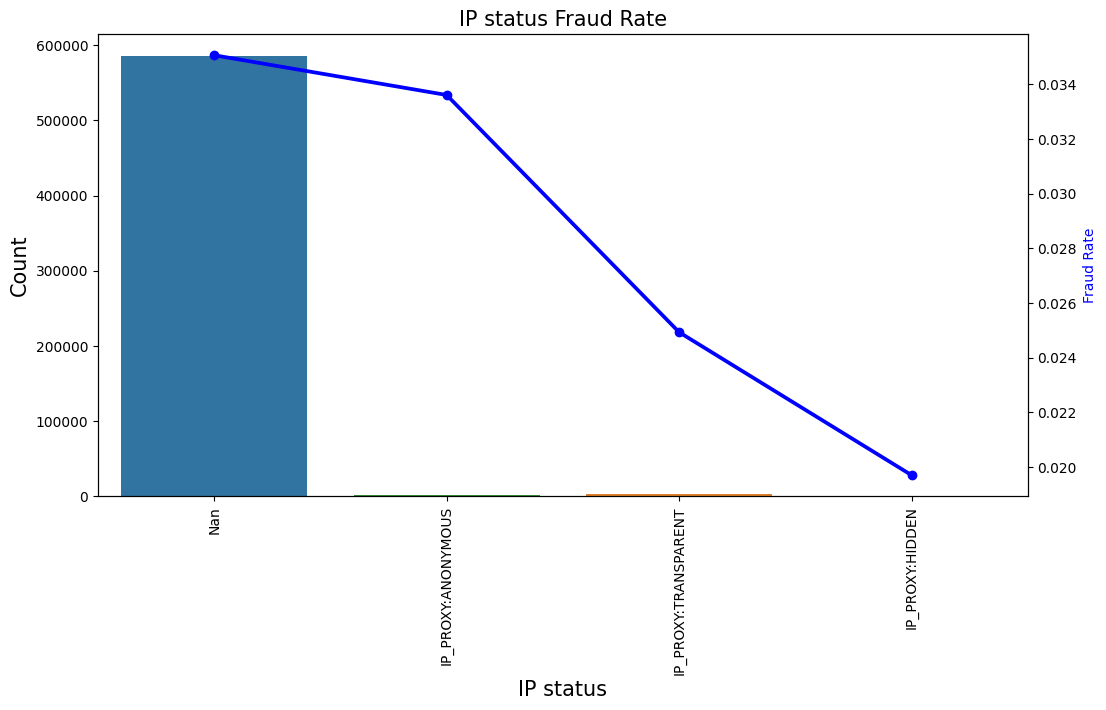

In [37]:
fraud_rate("id_23", "IP status", "IP status Fraud Rate", train_transaction_categorical)

	
We can see that Anonymous IP_Proxy has a higher fraud rate. This is logical as someone making a fraudulent transaction would want to higher their IP status. However, as we have many null values in this column, this feature may not be that useful

We shall also aggregate os and browser type

In [38]:
devices = train_transaction_categorical[["id_30", "id_31", "isFraud"]].copy()
devices.loc[:, "main_os"] = devices["id_30"].str.split(" ", expand=True)[0]
devices.loc[:, "browser"] = devices["id_31"].str.split(" ", expand=True)[0]

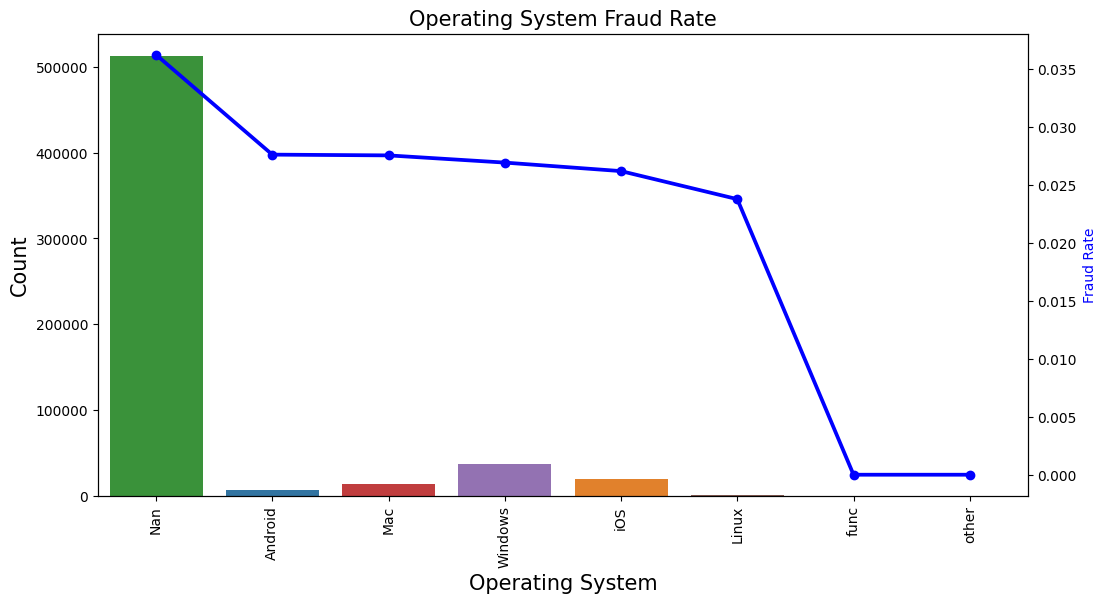

In [39]:
fraud_rate("main_os", "Operating System", "Operating System Fraud Rate", devices)

Fraud rate seem to be similar across the popular OSs.

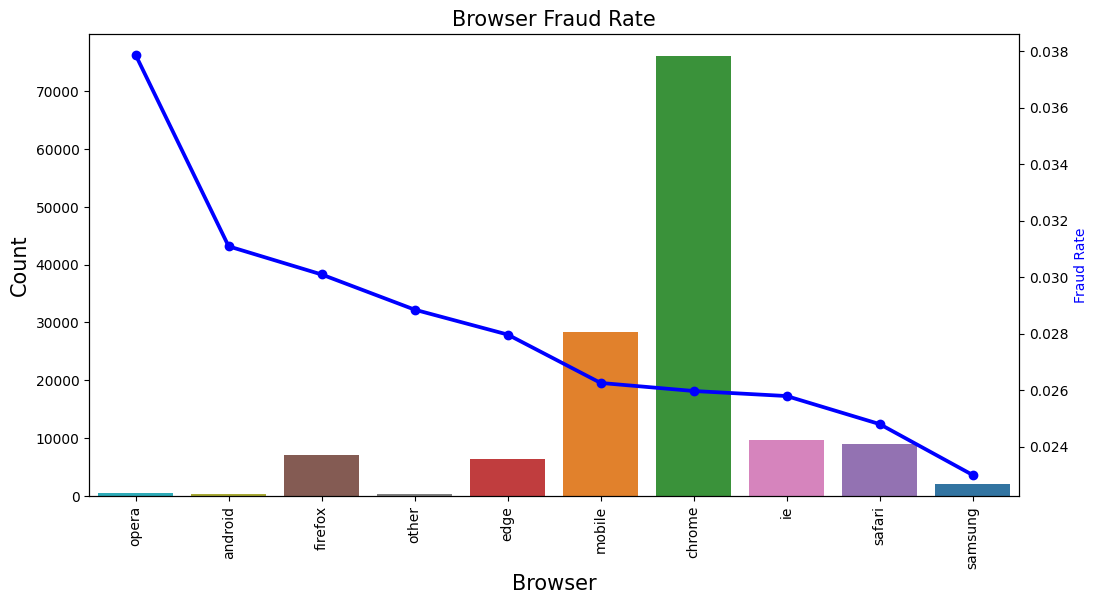

In [40]:
browser_list = devices.groupby('browser').filter(lambda x: len(x)>200)['browser'].unique()
fraud_rate("browser", "Browser", "Browser Fraud Rate", devices[devices['browser'].isin(browser_list)])

Opera, android and firefox have relatively high fraud rate

# 3. Numerical Analysis

In [41]:
def visualize_num_variable(variable, df=train_transaction):
    plt.figure(figsize=(12,18))
    plt.suptitle('Distribution of: {}'.format(variable), fontsize=22)

    plt.subplot(321)
    sns.distplot(df[variable], kde= False)
    plt.title('{} Distribution'.format(variable), fontsize = 15)

    plt.subplot(322)
    sns.distplot(np.log10(df[variable]), kde= False)
    plt.title('Log-transformed Distribution', fontsize = 15)


    plt.subplot(323)
    sns.distplot(df[df['isFraud'] == 0][variable], color = 'skyblue', kde= False, label = 'Not Fraud')
    sns.distplot(df[df['isFraud'] == 1][variable], color = 'red', kde= False , label = 'Fraud')
    plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
    plt.legend()

    plt.subplot(324)
    sns.distplot(np.log10(df[df['isFraud'] == 0][variable]), color = 'skyblue', kde= False, label = 'Not Fraud')
    sns.distplot(np.log10(df[df['isFraud'] == 1][variable]), color = 'red', kde= False , label = 'Fraud')
    plt.title('Log-transformed Distribution', fontsize = 15)
    plt.legend()
    plt.subplot(313)
    sns.boxplot(x = 'isFraud', y = variable, data = df)
    plt.title('Transaction Amount by Fraud', fontsize = 15,  weight='bold')

In [ ]:
train_transaction['C1'] = train_transaction['C1'].astype(int)

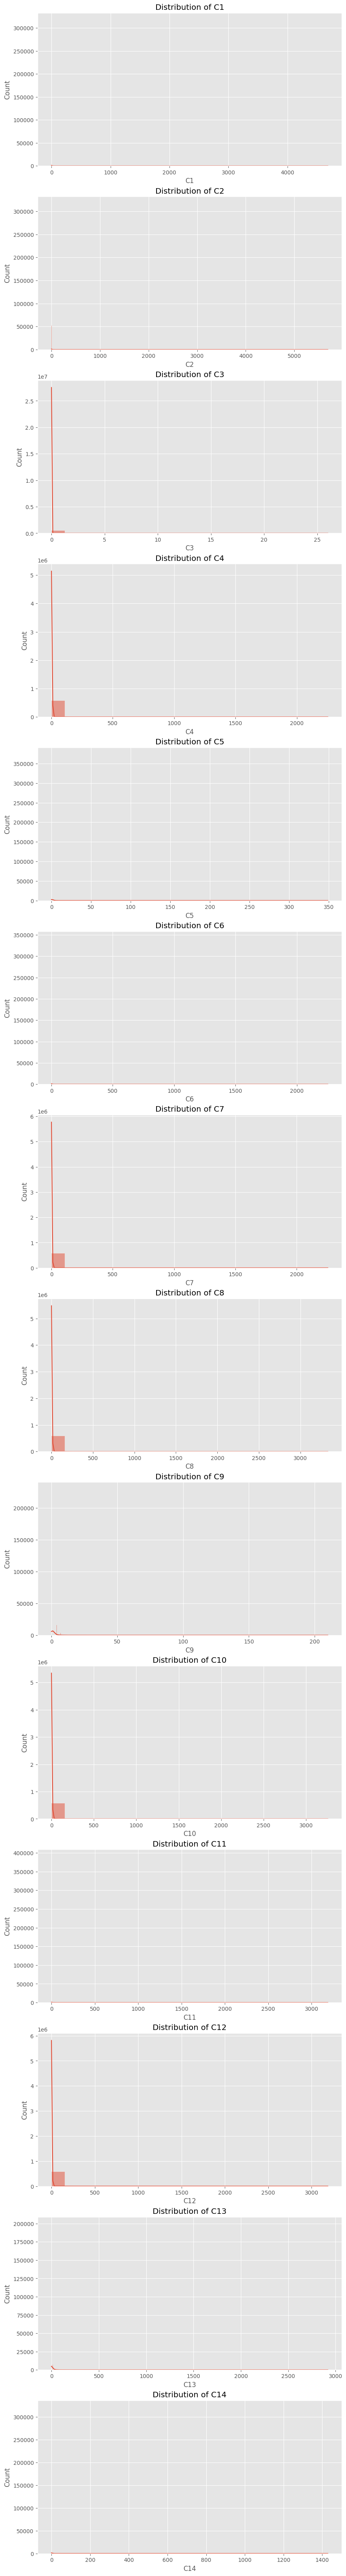

In [44]:
id_list = train_transaction.loc[:1, 'C1':'C14'].columns

fig, axes = plt.subplots(nrows=len(id_list), ncols=1, figsize=(10, 6*len(id_list)))

# Plot histograms for each column
for i, column in enumerate(id_list):
    sns.histplot(train_transaction[column], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {column}')

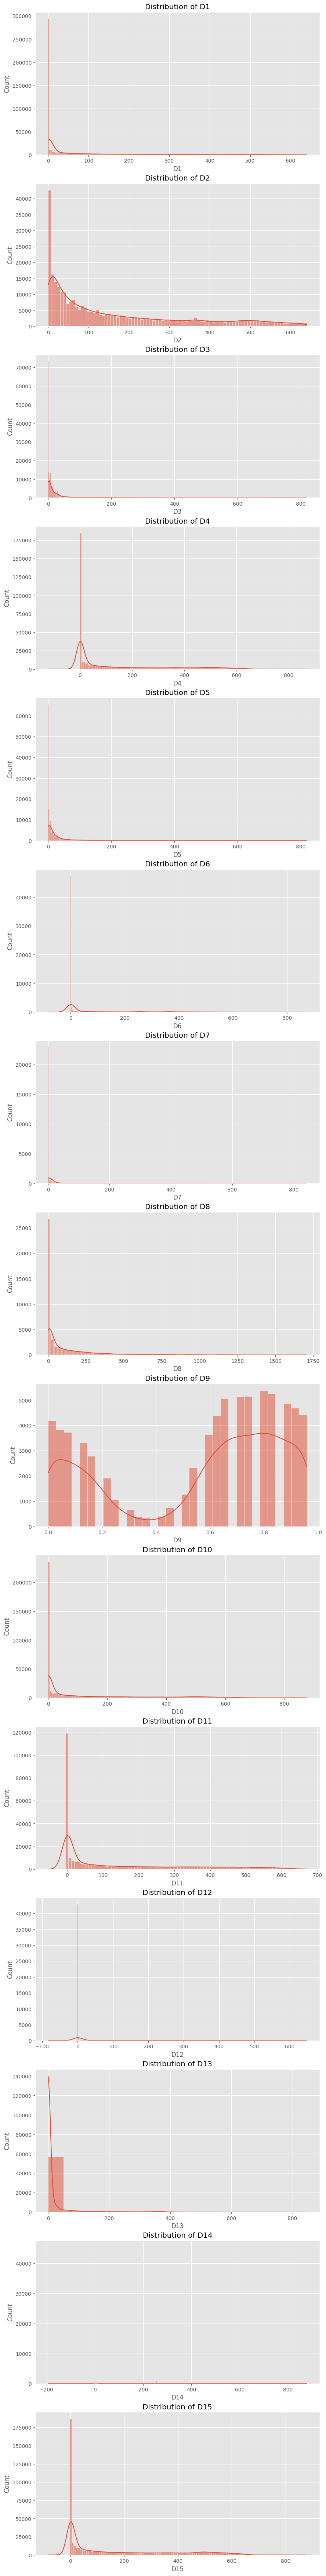

In [48]:
id_list = train_transaction.loc[:1, 'D1':'D15'].columns

fig, axes = plt.subplots(nrows=len(id_list), ncols=1, figsize=(10, 6*len(id_list)))

# Plot histograms for each column
for i, column in enumerate(id_list):
    sns.histplot(train_transaction[column], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {column}')

We can see from the graphs that the distribution of counts for D2, D9 vary significantly. We can use PCA to validate our observations and look for other relevant patterns.